In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
#from food.psql import *
from mytools.tools import get_logger
# logger = get_logger(engine,'bot_logs','food')
# logger.debug({'msg':'starting bot'})
from aiogram import Bot, Dispatcher, executor, types
from aiogram.types import ContentType
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.types.message import ContentTypes
from aiogram.dispatcher import FSMContext
from aiogram.contrib.fsm_storage.memory import MemoryStorage
from sqlalchemy import update
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.utils.callback_data import CallbackData
import typing
import numpy as np
import io


from food.paths import *


API_TOKEN = bot_token

from food.paths import *
#from food.search import *
import pandas as  pd
import pytz
timezones = pytz.all_timezones
import requests
from requests.structures import CaseInsensitiveDict
import urllib
from tzwhere import tzwhere

import nest_asyncio
nest_asyncio.apply()

def image2file_obj(img):
    o = io.BytesIO()
    f = img.format if img.format else 'jpeg'
    img.save(o, format=f)
    return o.getvalue()

In [3]:
from food.psql import engine

dev


In [4]:
from food.search import *

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


/home/dima/mytools/mytools/visual.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [5]:
def attribute_score(cals,values,scores):
    arrays = []
    for n in range(len(values)-1):
        arrays.append(np.stack([np.linspace(values[n],values[n+1]),np.flip(np.linspace(scores[n+1],scores[n]))]))
        formula = np.concatenate(arrays,axis=1)
        c = formula[0][formula[0] <cals][-1]

    return formula[1][formula[0]==c].astype(np.int32)[0]
    

In [6]:
protein_scores = ([0,10,20,35],
                  [0,80,100,80])
calore_scores  = ([0,100,150,200,300,400],
                  [100,100,70 ,60 ,50 ,30])

In [7]:
cals = 80
protein = 20

In [8]:
def get_food_score(cals,protein):
    return attribute_score(protein,protein_scores[0],protein_scores[1]),attribute_score(cals   ,calore_scores[0],calore_scores[1])

In [11]:
today_consumed = pd.read_sql( f"""select f.energy, f.protein, f.carb, f.fat, d.area,d.timestamp
                   from food.foods f
                   join food.dishes d on (f.id = d.food_id)
                   where d.user_id = {user_id} and 
                         d.timestamp > now() - interval '24 hours' and
                         d.area is not null""" ,engine).set_index("timestamp")
user_tz = engine.execute(f"""select value from food.user_properties 
                                where user_id={user_id} and
                                property='tz'
                                order by id desc limit 1""").first()

In [12]:
today_consumed

,energy,protein,carb,fat,area
timestamp,,,,,


In [13]:
def plot_nutrition(masks):
    attributes = ['energy','protein','carb','fat']
    nutrition ={}
    for m,a in zip(masks,attributes): nutrition[a] = int(m[m!=0].mean())
    return pd.DataFrame(nutrition,index = ['']).to_string()

In [14]:
def get_today_consumed(user_id):
    today_consumed = pd.read_sql(f"""select energy,grams,timestamp from {schema}.dishes
                                    where user_id = {user_id} and timestamp > now() - interval '24 hours'
                                    and grams is not null;""",engine).set_index("timestamp")
    
    
    today_consumed= today_consumed['energy']/100*today_consumed['grams']
    user_tz = engine.execute(f"""select value from food.user_properties 
                                where user_id={user_id} and
                                property='tz'
                                order by id desc limit 1""").first()

    user_tz = user_tz[0] if user_tz else 'UTC'
    today_consumed = today_consumed.tz_convert(user_tz)
    now = pd.Timestamp.now(tz = user_tz)
    today_consumed = today_consumed.reset_index()	
    this_morning = pd.Timestamp(year = now.year,month = now.month,day = now.day,hour = 3,tz = user_tz)
    today_consumed = today_consumed[today_consumed['timestamp'] > pd.Timestamp(this_morning)][0].sum()
    return int(today_consumed),user_tz

In [15]:
q = f"""select d.*
       from food.dishes d""" 

In [16]:
def get_today_consumed(user_id):
    today_consumed = pd.read_sql(f"""select energy,grams,timestamp from {schema}.dishes
                                    where user_id = {user_id} and timestamp > now() - interval '24 hours'
                                    and grams is not null;""",engine).set_index("timestamp")
    today_consumed= today_consumed['energy']/100*today_consumed['grams']
    user_tz = engine.execute(f"""select value from food.user_properties 
                                where user_id={user_id} and
                                property='tz'
                                order by id desc limit 1""").first()

In [11]:
async def async_image2file_obj(img):
    return image2file_obj(img)

async def async_search(url):
    return search(url)

async def async_visualize_array(*args,**kwargs):
    return visualize_array(*args,**kwargs)

In [65]:
bot = Bot(token=API_TOKEN)
storage = MemoryStorage()
dp = Dispatcher(bot, storage=storage)

In [66]:
dishes_table = Dishes.__table__

add_dish_cb     = CallbackData('add dish', 'action')
edit_dish_cb    = CallbackData('edit_dish', 'action')

Cause exception while getting updates.
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/asyncio/futures.py", line 284, in __await__
    yield self  # This tells Task to wait for completion.
  File

In [ ]:
def get_keyboard(t, unit = None):
    markup = types.InlineKeyboardMarkup()
    if t == 'add dish' :  
        markup.add(types.InlineKeyboardButton('add dish', callback_data=add_dish_cb.new(action='add_dish')))
         

    elif t == 'edit_dish':

        btns_text = ('remove','edit weight','add again')
        markup.add(*(types.InlineKeyboardButton(text, callback_data=edit_dish_cb.new(action=text)) for text in btns_text))

    return markup 

In [64]:

@dp.message_handler(content_types=ContentType.PHOTO,state='*')
async def process_photo(message: types.Message, state: FSMContext):
    await message.reply('yes')
    global m 
    global i
    global u
    m = message


    photo  = message['photo'][-1]
    await photo.download(reference_images_path/photo['file_id'])
    # image_url    = await photo.get_url()
    image_url      = f'https://dima.grankin.eu/reference_images/{photo["file_id"]}'
    
    img,clip_df,masks,urls,stats = await async_search(image_url)
    # img = visualize_array(masks[0].numpy(),img)
    
    i = img
    u = image_url
    
    print('started')


    
    img_o = await async_image2file_obj(img)
    await message.reply_photo(img_o,caption=f'{plot_nutrition(masks)} \n')
    
    
    print('finished')

if __name__ == '__main__': executor.start_polling(dp)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/stego_my/utils.py:180: DeprecationWarning: NEAR

started
finished


Goodbye!


photo reseived
retrun img
return nutrition value

if add:

    if area > min_area:
        keep adding your dishes to get your food score for today

    else:
        food score > 80:
        - you are doing great
        
        food score < 80:
            if high calorie: get a lower density food with the next dish
            if low protein : get more proteing containing food with the next dish
            
            
        
            
            
    
    
    
    

In [13]:
url = 'https://dima.grankin.eu/reference_images/AgACAgIAAxkBAAIKFWLjz26jI4-aVIsTZmHon_Zlb7rrAAJBxDEbFPIZSw3jSOUNCySqAQADAgADeQADKQQ'

In [14]:
img,clip_df,masks,urls,stats = await async_search(url)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f

In [29]:
masks[0][masks[0]!=0].shape[0]

185553

In [ ]:
1

In [16]:
urls

['https://dima.grankin.eu/fragment_reference_images/AgACAgIAAxkBAAIKFWLjz26jI4-aVIsTZmHon_Zlb7rrAAJBxDEbFPIZSw3jSOUNCySqAQADAgADeQADKQQ_48.jpg',
 'https://dima.grankin.eu/fragment_reference_images/AgACAgIAAxkBAAIKFWLjz26jI4-aVIsTZmHon_Zlb7rrAAJBxDEbFPIZSw3jSOUNCySqAQADAgADeQADKQQ_66.jpg',
 'https://dima.grankin.eu/fragment_reference_images/AgACAgIAAxkBAAIKFWLjz26jI4-aVIsTZmHon_Zlb7rrAAJBxDEbFPIZSw3jSOUNCySqAQADAgADeQADKQQ_stego.jpg']

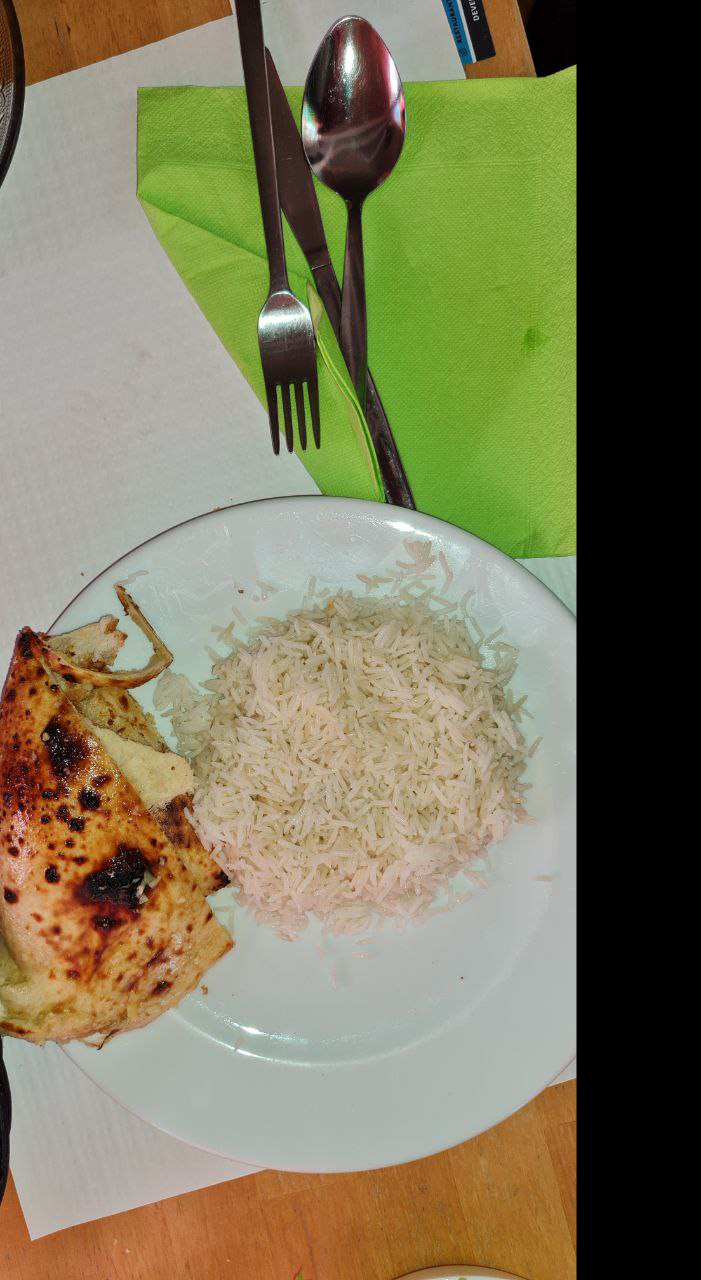

In [10]:
img

In [37]:
from food.psql import *

In [38]:
Dishes.

food.psql.Dishes

In [17]:
clip_df.

,id,description,category,energy,protein,carb,fat,text,clip,score,classes,area
1,1101623,"Rice, white, cooked, made with margarine",Rice,142.0,2.60,27.22,2.12,the food is rice . it has a little bit of ma...,"[0.0018506275, -0.023965847, -0.02183054, 0.03...",0.289932,67,101505
0,1098460,"Chicken breast, sauteed, skin eaten","Chicken, whole pieces",206.0,25.72,0.00,10.62,"the food is chicken, whole pieces . it has a l...","[-0.0038448547, 0.019303918, -0.015032307, 0.0...",0.270225,49,72946
2,1099551,"Chicken or turkey, rice, and vegetables includ...",Poultry mixed dishes,142.0,8.05,15.54,5.15,the food is poultry mixed dishes . it has a li...,"[0.0128670195, 0.035876185, -0.002930888, 0.04...",0.267949,1,11102


In [62]:
def plot_nutrition(masks):
    attributes = ['energy','protein','carb','fat']
    nutrition ={}
    for m,a in zip(masks,attributes): nutrition[a] = int(m[m!=0].mean())
    return pd.DataFrame(nutrition,index = ['']).to_string()

'  energy  protein  carb  fat\n     167       12    26    5'

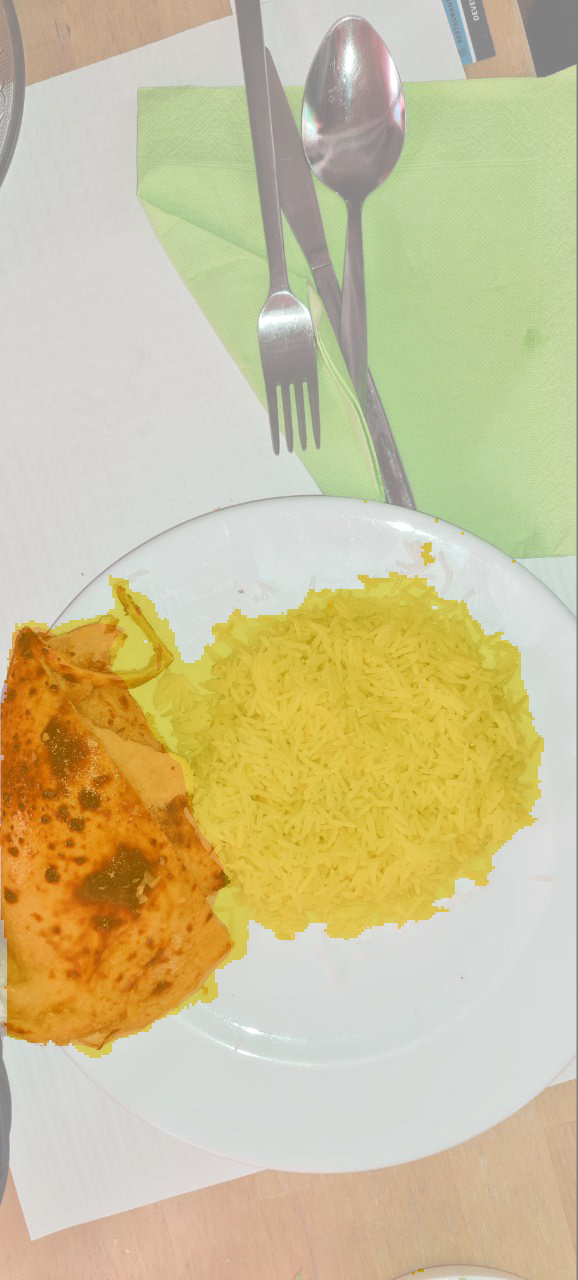

In [42]:
img

In [11]:
image2file_obj??

Signature: image2file_obj(img)
Docstring: <no docstring>
Source:   
def image2file_obj(img):
    o = io.BytesIO()
    img.save(o, format=i.format)
    return o.getvalue()
File:      /tmp/ipykernel_2354108/1279850320.py
Type:      function


In [12]:
img.format

In [15]:
img_o = image2file_obj(img)

In [16]:
img_o

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\x08\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x05\x00\x04\xbb\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd

In [10]:
photo  = m['photo'][-1]
await photo.download(reference_images_path/photo['file_id'])
# image_url    = await photo.get_url()
image_url      = f'https://dima.grankin.eu/reference_images/{photo["file_id"]}'

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


In [14]:
image_url

'https://dima.grankin.eu/reference_images/AgACAgIAAxkBAAIKAmLhn0SdD55hleSPR5q57eb-6Lb2AAIZvzEb6jQQS7YEy1gu7EwnAQADAgADeQADKQQ'

In [12]:
img,clip_df,masks,urls = search(image_url)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (1280,1279,3) (1280,1280,3) 

In [13]:
expand_boundaries

NameError: name 'expand_boundaries' is not defined

In [ ]:
img_o = await async_image2file_obj(i)

In [8]:
await m.reply_photo(img_o)

<Message {"message_id": 2478, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658772535, "reply_to_message": {"message_id": 2476, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658772488, "photo": [{"file_id": "AgACAgIAAxkBAAIJrGLe3Ahpju7CG2OfAjf0NNzEkNMCAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADcwADKQQ", "file_unique_id": "AQADQr0xG0MV8Up4", "file_size": 1212, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJrGLe3Ahpju7CG2OfAjf0NNzEkNMCAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADbQADKQQ", "file_unique_id": "AQADQr0xG0MV8Upy", "file_size": 16703, "width": 320, "height": 180}, {"file_id"

In [5]:
i

NameError: name 'i' is not defined

In [87]:
await m.reply_photo(image2file_obj(i))

<Message {"message_id": 2446, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658770476, "reply_to_message": {"message_id": 2445, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658770438, "photo": [{"file_id": "AgACAgIAAxkBAAIJjWLe1AYnqWxItAqPc6Oab3GKfY-pAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADcwADKQQ", "file_unique_id": "AQADQr0xG0MV8Up4", "file_size": 1212, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJjWLe1AYnqWxItAqPc6Oab3GKfY-pAAJCvTEbQxXxSkgVFMe0cp5XAQADAgADbQADKQQ", "file_unique_id": "AQADQr0xG0MV8Upy", "file_size": 16703, "width": 320, "height": 180}, {"file_id"

Cause exception while getting updates.
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/asyncio/futures.py", line 284, in __await__
    yield self  # This tells Task to wait for completion.
  File

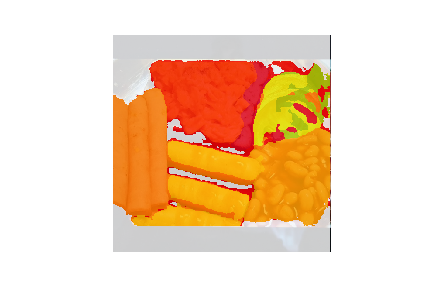

Cause exception while getting updates.
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/asyncio/futures.py", line 284, in __await__
    yield self  # This tells Task to wait for completion.
  File

In [81]:
i

In [69]:
import io

In [76]:
o = io.BytesIO()
i.save(o, format=i.format)
o = o.getvalue()

In [77]:
await m.reply_photo(o)

<Message {"message_id": 2441, "from": {"id": 5091011572, "is_bot": true, "first_name": "calorie_bot", "username": "food_classifier_bot"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658769360, "reply_to_message": {"message_id": 2438, "from": {"id": 78882798, "is_bot": false, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "language_code": "en"}, "chat": {"id": 78882798, "first_name": "Dmitry", "last_name": "Grankin", "username": "dmitry_grankin", "type": "private"}, "date": 1658768961, "photo": [{"file_id": "AgACAgIAAxkBAAIJhmLezkE6uExbu6e-IDmI92c9eV7_AALAwDEb8n74ShMXBTVsclUgAQADAgADcwADKQQ", "file_unique_id": "AQADwMAxG_J--Ep4", "file_size": 1209, "width": 90, "height": 51}, {"file_id": "AgACAgIAAxkBAAIJhmLezkE6uExbu6e-IDmI92c9eV7_AALAwDEb8n74ShMXBTVsclUgAQADAgADbQADKQQ", "file_unique_id": "AQADwMAxG_J--Epy", "file_size": 16215, "width": 320, "height": 180}, {"file_id"

In [64]:
await m.reply_photo(i)

Task exception was never retrieved
future: <Task finished name='Task-119' coro=<Dispatcher._process_polling_updates() done, defined at /home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiogram/dispatcher/dispatcher.py:407> exception=TypeError("Can not serialize value type: <class 'PIL.PngImagePlugin.PngImageFile'>\n headers: {}\n value: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=432x288 at 0x7FCDBC3F4AC0>")>
Traceback (most recent call last):
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/formdata.py", line 145, in _gen_form_data
    part = payload.get_payload(
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/payload.py", line 71, in get_payload
    return PAYLOAD_REGISTRY.get(data, *args, **kwargs)
  File "/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/aiohttp/payload.py", line 118, in get
    raise LookupError()
aiohttp.payload.LookupError

The above exception was the direct cause of the following exception

TypeError: Can not serialize value type: <class 'PIL.PngImagePlugin.PngImageFile'>
 headers: {}
 value: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=432x288 at 0x7FCDAC6FA4F0>

In [23]:
i = None
m = None

In [31]:
i

In [33]:
m

In [19]:
await bot.send_photo(message.from_user.id, img)

NameError: name 'message' is not defined

In [ ]:
await bot.send_photo(message.from_user.id, img)